# Dropout从零开始实现

In [ ]:
!pip install d2l
!pip install matplotlib==3.0

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

* 要实现单层的暂退法函数，从均匀分布$U[0, 1]$中抽取样本，样本数与这层神经网络的维度一致。
然后保留那些对应样本大于$p$的节点，把剩下的丢弃。

* 在下面的代码中，**实现 `dropout_layer` 函数，该函数以`dropout`的概率丢弃张量输入`X`中的元素**，如上所述重新缩放剩余部分：将剩余部分除以`1.0-dropout`。

In [17]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()   
    # (torch.rand(X.shape) > dropout)会返回一个True和Flase的张量
    # .float将True和Flase转换为1和0
    return mask * X / (1.0 - dropout) 
    # 缩放，为了保证期望不发生改变

* 可以通过下面几个例子来**测试`dropout_layer`函数**。将输入`X`通过暂退法操作，暂退概率分别为0、0.5和1。

In [4]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  4.,  0.,  8., 10.,  0.,  0.],
        [16., 18., 20., 22.,  0.,  0., 28., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


**定义模型参数**

* **定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元**

In [5]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

**定义模型**

* 可以将暂退法应用于每个隐藏层的输出（在激活函数之后），并且可以为每一层分别设置暂退概率：
常见的技巧是在靠近输入层的地方设置较低的暂退概率。
* 下面的模型将第一个和第二个隐藏层的暂退概率分别设置为0.2和0.5，并且暂退法只在训练期间有效。

In [6]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

**训练和测试**

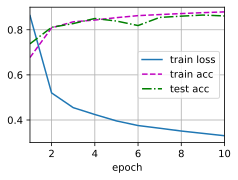

In [7]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# Dropout的简洁实现


* 对于深度学习框架的高级API，只需在每个全连接层之后添加一个`Dropout`层，
* 将暂退概率作为唯一的参数传递给它的构造函数。在训练时，`Dropout`层将根据指定的暂退概率随机丢弃上一层的输出（相当于下一层的输入）。在测试时，`Dropout`层仅传递数据。


In [8]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

* 对模型进行训练和测试

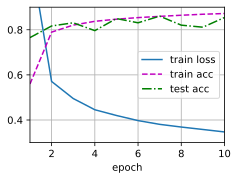

In [9]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)